# 只采用 input - PWL - lattice 的网络

In [1]:
import sys
import common
import argparse
import datasets
import numpy as np
import pandas as pd

from tqdm import tqdm
from matplotlib import pyplot as plt
import estimators as estimators_lib
import itertools
import tensorflow as tf
import tensorflow_lattice as tfl

from query_func import *
from models import LatticeCDF

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--dataset", type=str, default="test-2", help="Dataset.")
parser.add_argument("--query-size", type=int, default=10000, help="query size")
parser.add_argument("--min-conditions", type=int, default=1, help="min num of conditions")
parser.add_argument("--max-conditions", type=int, default=2, help="max num of conditions")
parser.add_argument("--epochs", type=int, default=10000, help="Number of epochs to train for.")
parser.add_argument("--bs", type=int, default=1000, help="Batch size.")
parser.add_argument("--loss", type=str, default="MSE", help="Loss.")
parser.add_argument("--lattice-size", type=int, default=2, help="Lattice size.")
parser.add_argument("--lr", type=float, default=1e-3, help="learning rate")
parser.add_argument("--seed", type=int, default=42, help="Random seed")

try:
    args = parser.parse_args()
except:
    # args = parser.parse_args([])
    args, unknown = parser.parse_known_args()

usage: ipykernel_launcher.py [-h] [--dataset DATASET]
                             [--query-size QUERY_SIZE]
                             [--min-conditions MIN_CONDITIONS]
                             [--max-conditions MAX_CONDITIONS]
                             [--epochs EPOCHS] [--bs BS] [--loss LOSS]
                             [--lattice-size LATTICE_SIZE] [--lr LR]
                             [--seed SEED]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/chun/Library/Jupyter/runtime/kernel-v2-32689kyEqwxIrXz48.json


In [3]:
OPS = {">": np.greater, "<": np.less, ">=": np.greater_equal, "<=": np.less_equal, "=": np.equal}

table = datasets.LoadDataset(f"datasets/{args.dataset}.csv", args.dataset)

print("Begin Generating Random Queries ...")
rng = np.random.RandomState(args.seed)
query_set = [
    GenerateQuery(table, args.min_conditions, args.max_conditions + 1, rng, args.dataset)
    for _ in tqdm(range(args.query_size))
]
print("Done.\n")

print("Begin Intervalization ...")
table_size = table.data.shape
n_row = table_size[0]
n_column = table_size[1]
unique_intervals = dictionary_column_interval(table_size, query_set)
column_interval_number = count_column_unique_interval(unique_intervals)
print("Done.\n")

Begin Generating Random Queries ...


100%|██████████| 10000/10000 [00:01<00:00, 5364.27it/s]

Done.

Begin Intervalization ...
Done.



In [4]:
print(query_set[0])

(array([Column(0, distribution_size=5)], dtype=object), array([0]), array([['<=']], dtype=object), array([[9]]), 0.8)


In [5]:
column_interval_number

[5, 5]

In [6]:
# 修改 x = [sys.maxsize] * n_column     # 这里使用每个col_unique_interval的最后一个元素即可
# 如果使用两个input的话，一个修改为最大，一个修改为最小

In [7]:
train_X = []
train_Y = []
for query in query_set:
    x = [sys.maxsize] * n_column  # 这里使用每个col_unique_interval的最后一个元素即可
    _, col_idxs, _, vals, sel = query
    for i in range(len(col_idxs)):
        x[col_idxs[i]] = vals[i][0]
    train_X.append(x)
    train_Y.append(sel)

train_X = np.array(train_X).astype(np.float32)
train_Y = np.array(train_Y).astype(np.float32).reshape(-1, 1)

train = np.concatenate((train_X, train_Y), axis=1)
train = np.unique(train, axis=0)  # 这里要不要使用 unique ？

train_X, train_Y = np.hsplit(train, [-1])

# feat_mins = train_X.min(axis=0)
# feat_maxs = train_X.max(axis=0)
# df_train = pd.DataFrame(train, columns=[f'col_{i}' for i in range(train.shape[1]-1)] + ['sel'])

In [8]:
# 要加一个最大值，让train_Y的最大值为1
# 加一个0～internalization之间的值，
# 把四周的边界补齐，这个可以做到，中间的点做不到, 补的时候可以用三次样条自动补嘛？样条可以保持单调性吗？可以在PWL直接改成三次样条吗

In [9]:
model_name = (
    f"{args.dataset}_{args.query_size}_({args.min_conditions}, {args.max_conditions})_{args.loss}"
)
m = LatticeCDF(
    model_name,
    table_size,
    unique_intervals,
    pwl_keypoints=None,
    lattice_size=args.lattice_size,
)

2024-06-11 04:49:22.231765: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-11 04:49:22.231792: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-11 04:49:22.231800: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-11 04:49:22.231834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-11 04:49:22.231850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 col_0 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 col_1 (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 pwl_calibration (PWLCalibr  (None, 1)                    5         ['col_0[0][0]']               
 ation)                                                                                           
                                                                                                  
 pwl_calibration_1 (PWLCali  (None, 1)                    5         ['col_1[0][0]']           

In [10]:
m.fit(train_X, train_Y, lr=args.lr, bs=args.bs, epochs=args.epochs, loss=args.loss)

Epoch 1/10000


2024-06-11 04:49:23.193019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-06-11 04:49:23.252538: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1/1 [==============================] - ETA: 0s - loss: 0.0224
Epoch 1: loss improved from inf to 0.02243, saving model to saved_models/test-2_10000_(1, 2)_MSE_weight.hdf5
1/1 [==============================] - 1s 843ms/step - loss: 0.0224 - lr: 0.0010
Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: 0.0218
Epoch 2: loss improved from 0.02243 to 0.02176, saving model to saved_models/test-2_10000_(1, 2)_MSE_weight.hdf5
1/1 [==============================] - 0s 55ms/step - loss: 0.0218 - lr: 0.0010
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: 0.0211
Epoch 3: loss improved from 0.02176 to 0.02112, saving model to saved_models/test-2_10000_(1, 2)_MSE_weight.hdf5
1/1 [==============================] - 0s 52ms/step - loss: 0.0211 - lr: 0.0010
Epoch 4/10000
1/1 [==============================] - ETA: 0s - loss: 0.0205
Epoch 4: loss improved from 0.02112 to 0.02050, saving model to saved_models/test-2_10000_(1, 2)_MSE_weight.hdf5
1/1 [================

/opt/homebrew/Caskroom/miniforge/base/envs/lattice/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)  # 所有 unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)

In [27]:
grid_pred = m.predict(grid)

1/1 [==============================] - 0s 20ms/step


In [28]:
dataNew = None
dataNew = m.generate_3(grid, grid_pred)
dataNew.to_csv("dataNew.csv", index=False, header=False)
# dataNew

  0%|          | 0/25 [00:00<?, ?it/s]/Volumes/Macintosh HD2/科研/AIDB/LPALG/models.py:369: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataNew = pd.concat([dataNew, df3], ignore_index=True)
100%|██████████| 25/25 [00:00<00:00, 3629.55it/s]

Finished table generation


In [29]:
Q_error = calculate_Q_error(dataNew, query_set, n_row)
print_Q_error(Q_error, args)

100%|██████████| 10000/10000 [00:00<00:00, 15566.22it/s]



 Q-error of Lattice (dataset=test-2, query size=10000, condition=[1, 2], loss=MSE):

min:    1.0
10:     1.0
20:     1.0
30:     1.0
40:     1.0
median: 1.0
60:     1.125
70:     1.1666666666666667
80:     1.25
90:     1.25
95:     1.4999999999999998
99:     1.4999999999999998
max:    1.4999999999999998
mean:   1.1069976190476192


In [30]:
dataNew = None
dataNew = m.generate_4(grid, grid_pred)
dataNew.to_csv("dataNew.csv", index=False, header=False)
# dataNew

100%|██████████| 25/25 [00:00<00:00, 4245.25it/s]

Completed table generation


In [31]:
Q_error = calculate_Q_error(dataNew, query_set, n_row)
print_Q_error(Q_error, args)

100%|██████████| 10000/10000 [00:00<00:00, 14199.78it/s]



 Q-error of Lattice (dataset=test-2, query size=10000, condition=[1, 2], loss=MSE):

min:    1.0
10:     1.0
20:     1.0
30:     1.0
40:     1.0
median: 1.0
60:     1.125
70:     1.1666666666666667
80:     1.25
90:     1.25
95:     1.4999999999999998
99:     1.4999999999999998
max:    1.4999999999999998
mean:   1.1069976190476192


In [32]:
dataNew = None
dataNew = m.generate_5(grid, grid_pred)
dataNew.to_csv("dataNew.csv", index=False, header=False)
# dataNew

100%|██████████| 25/25 [00:00<00:00, 117421.72it/s]

Completed table generation


In [33]:
Q_error = calculate_Q_error(dataNew, query_set, n_row)
print_Q_error(Q_error, args)

100%|██████████| 10000/10000 [00:00<00:00, 15466.25it/s]



 Q-error of Lattice (dataset=test-2, query size=10000, condition=[1, 2], loss=MSE):

min:    1.0
10:     1.0
20:     1.0
30:     1.0
40:     1.0
median: 1.0
60:     1.125
70:     1.1666666666666667
80:     1.25
90:     1.25
95:     1.4999999999999998
99:     1.4999999999999998
max:    1.4999999999999998
mean:   1.1069976190476192


In [34]:
dataNew

,col_0,col_1
0,2.0,9.0
1,2.0,9.0
2,2.0,10.0
3,3.0,4.0
4,5.0,1.0
5,9.0,1.0
6,9.0,9.0
7,10.0,1.0
8,10.0,1.0
9,10.0,10.0


<Axes: xlabel='col_0', ylabel='col_1'>

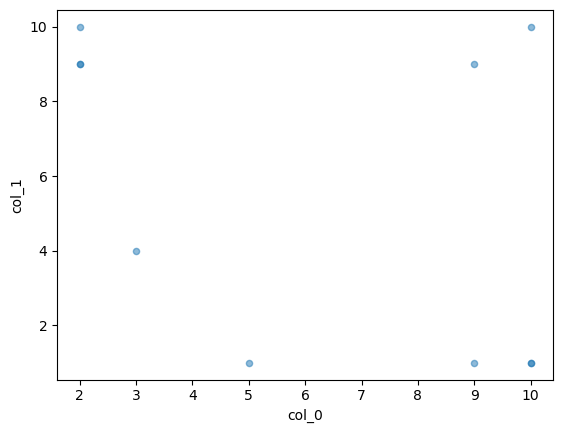

In [35]:
dataNew.plot(kind="scatter", x="col_0", y="col_1", alpha=0.5)

In [19]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### 测试简单分布中，使用generate是否能得到正确的分布

In [21]:
data = np.array([[2, 9], [5, 4], [3, 1], [9, 3], [2, 9], [2, 9], [3, 10], [9, 1], [10, 1], [10, 1]])
values = [range(1, 11), range(1, 11)]
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
results = []
df = pd.DataFrame(data, columns=["x", "y"])
for x in range(1, 11):
    for y in range(1, 11):
        count = df[(df["x"] <= x) & (df["y"] <= y)].shape[0]
        results.append(count)
pred = np.array(results).reshape(-1, 1) / df.shape[0]

In [22]:
n_row = df.shape[0]
n_column = df.shape[1]

In [23]:
def generate_5(grid, pred=None):
    # 使用 numpy / calculate_query_cardinality_numpy / np.concatenate
    if pred is None:
        pred = m.predict(grid)
    assert pred.shape[0] == grid.shape[0]
    # generate by row, one query may generate several rows
    column_names = [f"col_{i}" for i in range(n_column)]
    # dataNew = pd.DataFrame(columns=column_names)

    count = 0
    ArrayNew = None
    ops = ["<="] * n_column
    pred = (pred * n_row).astype(int)  # Case 1: change 0.8 to 0, 1.8 to 1
    for i in tqdm(range(grid.shape[0])):
        vals = grid[i]
        card = pred[i, 0] - calculate_query_cardinality_numpy(ArrayNew, ops, vals)

        if card >= 1:
            array3 = np.repeat(vals, card).reshape(n_column, card).T
            ArrayNew = array3 if ArrayNew is None else np.concatenate((ArrayNew, array3), axis=0)
            # dataNew = pd.DataFrame(ArrayNew, columns=column_names)
            count += card
            if count > n_row:
                print(
                    f"Reached table max row length({n_row}) in {i}-th row of grid with grid value of {vals}, stop generation."
                )
                break
    else:
        print("Complete table generation")
        # if count < n_row:
        #     print(
        #         f"Reached table max row length({n_row}) in the last row of grid, stop generation."
        #     )
        #     # 如果不足需要补 系统最大值
        #     # dataNew = pd.DataFrame(ArrayNew, columns=column_names)
        return pd.DataFrame(ArrayNew, columns=column_names)
    return pd.DataFrame(ArrayNew, columns=column_names).iloc[:n_row, :]

In [24]:
dataNew = generate_5(grid, pred)
dataNew

100%|██████████| 100/100 [00:00<00:00, 163904.03it/s]

Complete table generation


,col_0,col_1
0,2.0,9.0
1,2.0,9.0
2,2.0,9.0
3,3.0,1.0
4,3.0,10.0
5,5.0,4.0
6,9.0,1.0
7,9.0,3.0
8,10.0,1.0
9,10.0,1.0


<Axes: xlabel='col_0', ylabel='col_1'>

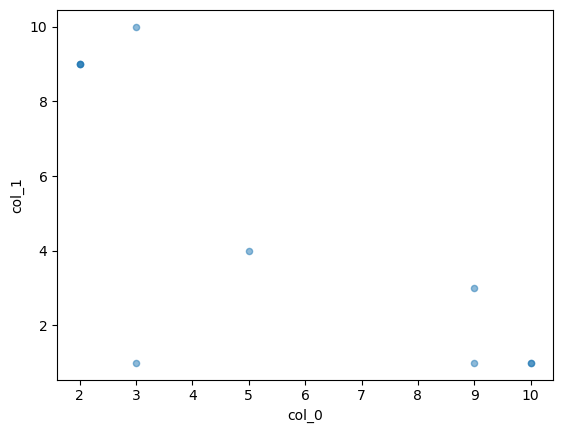

In [25]:
dataNew.plot(kind="scatter", x="col_0", y="col_1", alpha=0.5)

In [ ]:
# main写成 SingleTable.py
# 关于 class中的load方法，hdf5与h5的区别是什么？应该如何load？load权重还是模型结构一起load？哪一种更好？

### generate_from_batches

In [ ]:
# 确认一下，下面 batch生成的数组格式和grid 的格式是否是相同的，shape

In [ ]:
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)

In [ ]:
### 修改成 generate_from_batches(grid=None, pred=None)


# 写一个def _generate_grid_batches 方法(下面代码块的重命名）
def generate_batches(values, batch_size):
    iterator = itertools.product(*values)
    while True:
        batch = list(itertools.islice(iterator, batch_size))
        if not batch:
            break
        yield np.array(batch).astype(np.float32)


# unique_intervals = {
#     "A": list(range(1, 101)),
#     "B": list(range(1, 101)),
#     "C": list(range(1, 101)),
#     "D": list(range(1, 101)),
#     "E": list(range(1, 101)),
# }
values = [v for v in unique_intervals.values()]
batch_size = 10000  # 根据实际需要调整批处理大小
total_combinations = np.prod([len(v) for v in values])

processed_batches = []
for batch in tqdm(
    generate_batches(values, batch_size), total=(total_combinations // batch_size) + 1
):
    processed_batch = batch  # 这里可以添加处理逻辑
    processed_batches.append(processed_batch)

# 将所有处理后的批次合并
final_array = np.vstack(processed_batches)

#### 为什么 kl散度是负数，修改 epoch为一个很小的值，看看是否会出现负数

In [ ]:
# 可能与网络的初始化输出值有关？
# 使用 kl散度是否时正确的，如何使用神经网络进行最大似然估计，似然与kl散度之间的关系是什么？

In [ ]:
grid_pred

In [ ]:
train_X

In [ ]:
train_X.shape

In [ ]:
train_Y.shape

In [ ]:
m.predict(train_X)

In [ ]:
# 2024/06/06 update
## 计算 Q-error 的速度：calculate_Q_error > calculate_Q_error_old, 二者的准确性相同, 目前的速度已经很快了
## 生成表的速度：generate_3 > generate > generate_2，之后考虑用numpy的concatenate来替代pd的concat，进一步提升生成速度，第二个思路：如果采用 auto regressive 模型,按列生成是否可以借助 gpu 来加速，
## 生成表的准确性：generate = generate_2 约等于 generate_3(有时候高，有时候低，误差不大，0.1与0.09999999的差别)

# 画图

In [ ]:
# 把plot 整合到 lattice里，或者单独写几个函数

In [ ]:
grid_pred = m.predict(grid)

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(grid_pred, "bo")

In [ ]:
fig1 = plt.figure(figsize=(15, 8))
ax1 = plt.axes(projection="3d")

# xx = unique_intervals[1]
# yy = unique_intervals[0]
# X, Y = np.meshgrid(xx, yy)

X = grid[:, 1].reshape(column_interval_number[0], column_interval_number[1])  # 这样也可以
Y = grid[:, 0].reshape(column_interval_number[0], column_interval_number[1])
Z = grid_pred.reshape(column_interval_number[0], column_interval_number[1])

ax1.plot_surface(X, Y, Z, cmap="viridis")
plt.show()

In [ ]:
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap="viridis")

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # 这个是啥

cbar = fig2.colorbar(cs)  # 让colorbar细粒度更高一点
plt.show()

In [ ]:
# 画一下原生的图做对比，是否需要更光滑
# 变得光滑：
# 1. 数据预处理，缩放，标准化
# 2. 凸函数
# 3. lattice正则器

In [ ]:
# query 对网格的覆盖率 散点图
fig4 = plt.figure(figsize=(10, 10))
xtick = unique_intervals[0]
ytick = unique_intervals[1]
plt.scatter(train_X[:, 0], train_X[:, 1], c="b")
plt.vlines(xtick, min(ytick), max(ytick), colors="green")
plt.hlines(ytick, min(xtick), max(xtick), colors="green")
plt.show()

# Lattice 其它尝试

In [ ]:
# 对比，对query做unique 和 不做unique的误差

In [ ]:
# 对比传入table unique value 和 只传入 unique_intervals的模型优化效果

In [ ]:
# table unique value
data = table.data.to_numpy()
unique_vals = []
for i in range(data.shape[1]):
    unique_vals.append(np.unique(data[:, i]))

In [ ]:
unique_vals

# 尝试 tfl.configs.FeatureConfig

In [ ]:
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.01

In [ ]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=df_train,
    y=df_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    shuffle=False,
)

# feature_analysis_input_fn is used for TF Lattice estimators.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=df_train,
    y=df_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

In [ ]:
feature_columns = [
    tf.feature_column.numeric_column("col_0"),
    tf.feature_column.numeric_column("col_1"),
    tf.feature_column.numeric_column("col_2"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="col_0",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
    ]
)
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)

In [ ]:
from IPython.core.pylabtools import figsize

In [ ]:
def save_and_visualize_lattice(tfl_estimator):
    saved_model_path = tfl_estimator.export_saved_model(
        "/tmp/TensorFlow_Lattice_101/",
        tf.estimator.export.build_parsing_serving_input_receiver_fn(
            feature_spec=tf.feature_column.make_parse_example_spec(feature_columns)
        ),
    )
    model_graph = tfl.estimators.get_model_graph(saved_model_path)
    figsize(8, 8)
    tfl.visualization.draw_model_graph(model_graph)
    return model_graph


_ = save_and_visualize_lattice(tfl_estimator)

In [ ]:
def query_to_lattice_input(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    x = [sys.maxsize] * n_column
    for i in range(n_column):
        column_interval[i] = set(
            [0, sys.maxsize]
        )  # use set([0, sys.maxsize]) to adapt '>' and '<'.
    for query in query_set:
        col_idxs = query[1]
        vals = query[3]
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        if not v:
            column_interval[k] = [0]
        else:
            column_interval[k] = sorted(list(v))
    return column_interval